In [0]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn import model_selection
from sklearn.metrics import mean_squared_error

In [2]:
from os.path import join
from google.colab import drive

ROOT = "/content/drive"
drive.mount(ROOT)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
PROJ = "My Drive/Colab Notebooks/AML Workspace/EM_KDE_imputation" # This is a custom path.
PROJECT_PATH = join(ROOT, PROJ)

In [0]:
from importlib.machinery import SourceFileLoader
utils = SourceFileLoader('utils', join(PROJECT_PATH, 'utils.py')).load_module()
plot = SourceFileLoader('plot', join(PROJECT_PATH, 'plot.py')).load_module()

In [0]:
from utils import remove_random_value, remove_dim, conditional_expectation, e_step, m_step, \
    calculate_log_likelihood, is_converged
from plot import plot_kde

 Load data

In [0]:
data = loadmat(join(ROOT, 'My Drive/Colab Notebooks/AML Workspace/faithfull/faithful.mat'))['X']

 Real world data (may make sense to crop end, since it's quite big)<br>

In [0]:
# data = np.genfromtxt(join(ROOT, 'My Drive/Colab Notebooks/AML Workspace/data/winequality-white.csv'), delimiter=';')[1:,:80]

 Testing with higher dimension data<br>

In [0]:
# np.random.shuffle(data)<br>
# data = np.concatenate([data, loadmat('../faithfull/faithful.mat')['X']], axis=1)

In [0]:
raw_data = data  # taking only a small part for testing
data = np.array(raw_data[:-10])
[damaged_data, removed_values] = remove_random_value(raw_data[-10:])
medians = np.median(data, axis = 0)


In [0]:
num_data, dim = data.shape

K-fold cross validation

In [0]:
K = num_data
CV = model_selection.KFold(n_splits=K, shuffle=False)

 Loop until you're happy

In [12]:
epsilon = 1e-3
sigma = np.eye(dim)
log_likelihood = np.asarray([])
i = 0
while True:
    i += 1
    sigmas = []
    R = np.linalg.cholesky(sigma)
    A = data.dot(np.linalg.inv(R).T)
    for train_index, test_index in CV.split(A):
        # extract training and test set for current CV fold
        a_test = A[test_index, :]
        a_train = A[train_index, :]
        x_test = data[test_index, :]
        x_train = data[train_index, :]

        # E step
        responsibility = e_step(a_test, a_train, R)

        # M step
        sigmas.append(m_step(x_test, x_train, responsibility))
    sigma = np.array(sigmas).sum(axis=1).mean(axis=0)
    R = np.linalg.cholesky(sigma)
    A = data.dot(np.linalg.inv(R).T)
    _log_likelihood = []
    for train_index, test_index in CV.split(A):
        # extract training and test set for current CV fold
        x_train = A[train_index, :]
        x_test = A[test_index, :]
        _log_likelihood.append(calculate_log_likelihood(x_test, x_train, R))
    log_likelihood = np.append(log_likelihood, np.asarray(_log_likelihood).mean())
    if is_converged(log_likelihood, epsilon):
        break

Run 1, log likelihood: 0.014753069834414304
Run 2, log likelihood: 0.016543309169945588, change: 0.12134690309370155
Run 3, log likelihood: 0.01749107985243791, change: 0.057290272022126665
Run 4, log likelihood: 0.018078529381674355, change: 0.033585663903682006
Run 5, log likelihood: 0.018472110712227666, change: 0.02177064971624687
Run 6, log likelihood: 0.018752609275715506, change: 0.015184976306046316
Run 7, log likelihood: 0.01896371000108556, change: 0.011257138794195987
Run 8, log likelihood: 0.01912890261950649, change: 0.008710986321319725
Run 9, log likelihood: 0.019260452823961327, change: 0.006877038744537822
Run 10, log likelihood: 0.019365332309571107, change: 0.0054453281326440894
Run 11, log likelihood: 0.019448510994186485, change: 0.004295236626239873
Run 12, log likelihood: 0.019514110679648904, change: 0.0033729926924497278
Run 13, log likelihood: 0.019565613044403414, change: 0.00263923709360836
Run 14, log likelihood: 0.019605885962624994, change: 0.002058351973

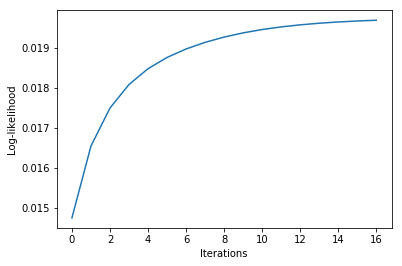

In [13]:
plt.figure(1)
plt.plot(log_likelihood)
plt.xlabel('Iterations')
plt.ylabel('Log-likelihood')
plt.show()


<br>
sigma = [[4.28747436e-02, 2.92396851e-01, 2.46394066e-04, 1.05465785e-01],<br>
         [2.92396851e-01, 1.44238149e+01, 4.95674770e-02, -1.75754718e+00],<br>
         [2.46394066e-04, 4.95674770e-02, 5.51668545e-02, 2.07264980e-01],<br>
         [1.05465785e-01, -1.75754718e+00, 2.07264980e-01, 1.57786340e+01]]<br>
sigma = [[0.0322203, 0.0194771],<br>
         [0.0194771, 3.8548159]]<br>


In [0]:
imputed_values = []
restored_data = []
median_impute = []
for test_data in damaged_data:
    # get index of missing dimension
    missing_dim = [idx for idx, value in enumerate(test_data) if np.isnan(value)][0]

    # remove data of that dimension
    train_data = data
    reduced_train_data = np.delete(train_data, missing_dim, axis=1)
    test_data = np.delete(test_data, missing_dim, axis=0)
    reduced_sigma = remove_dim(sigma, missing_dim)

    # create transformed data
    R = np.linalg.cholesky(reduced_sigma)
    R_inv_T = np.linalg.inv(R).T
    a_train = reduced_train_data.dot(R_inv_T)
    a_test = test_data.dot(R_inv_T)
    responsibility = np.squeeze(e_step(a_test, a_train, R))
    cond_exp = np.array([conditional_expectation(mean, test_data, sigma, missing_dim) for mean in train_data])
    imputed_value = np.sum(np.multiply(cond_exp, responsibility))
    imputed_values.append(imputed_value)
    restored_element = np.insert(test_data, missing_dim, imputed_value)
    median_impute.append(medians[missing_dim])
    restored_data.append(restored_element)

In [0]:
median_impute = np.array(median_impute)
restored_data = np.array(restored_data)
imputed_values = np.array(imputed_values)

In [0]:
divergence = np.abs(removed_values - imputed_values) / removed_values
divergence_median = np.abs(removed_values - median_impute) / removed_values
mse = (removed_values - imputed_values)**2 # mean_squared_error(removed_values, imputed_values)
mse_median = (removed_values - median_impute)**2

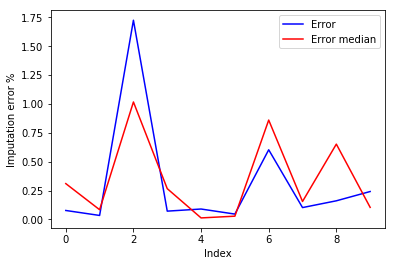

In [35]:
plt.figure(2)

plt.plot(np.arange(len(divergence)), divergence, '-b', label='Error')
plt.plot(np.arange(len(divergence)), divergence_median, '-r', label='Error median')
leg = plt.legend()
plt.xlabel('Index')
plt.ylabel('Imputation error %')
plt.show()

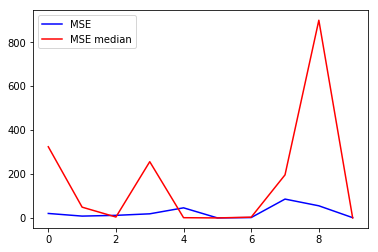

In [34]:
plt.figure(3)

plt.plot(np.arange(len(mse)), mse, '-b', label='MSE')
plt.plot(np.arange(len(mse)), mse_median, '-r', label='MSE median')
leg = plt.legend()
plt.xlabel('Index')
plt.ylabel('Imputation error MSE')
plt.show()

10

In [0]:
plot_kde(data, sigma, 0.1)